In [1]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

In [2]:
train = pd.read_csv("emnist-letters-train.csv", header=None)
test = pd.read_csv("emnist-letters-test.csv", header=None)

In [3]:
mappings = {}
with open("emnist-letters-mapping.txt") as f:
    for line in f.readlines():
        code, lower, upper = line.split()
        mappings[int(code)] = chr(int(lower))

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def display_images(imgs, names, max_imgs=100):
    """ Displays images and their corresponding names"""
    ncols = 10
    nrows = min(max_imgs // ncols, len(imgs) // ncols + 0 if len(imgs) % ncols == 0 else 1)

    f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize = (ncols,nrows))

    for ax, img, name in zip(axes.ravel(), imgs, names):
        ax.imshow(img)
        ax.set_title(name)

    plt.show()    

In [6]:
def process_emnist(arr, mappings):
    """ Process emnist letters by applying rotations, a flip and dividing by 255 """
    X = np.array(arr.iloc[:,1:]).reshape([-1,28,28])
    X = np.rot90(X, axes=(1,2))
    X = np.flip(X, axis=(1))
    X = X.astype(np.float32) / 255.0
    y = np.array(arr.iloc[:,0])
    y = [mappings.get(code, code) for code in y]
    return X, y

In [7]:
X_train, y_train = process_emnist(train, mappings)
X_test, y_test = process_emnist(test, mappings)

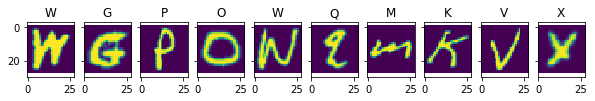

In [8]:
display_images(X_train[:10],y_train[:10])

In [9]:
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from keras import objectives
import numpy as np
from itertools import product

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
batch_size = 100
digit_size = 28
original_dim = (digit_size, digit_size)
original_dim_flat = np.prod(original_dim)
latent_dim = 2
intermediate_dim = 512
epochs = 100
epsilon_std = 1.0

In [11]:
def sampling(args):
    """ Returns a noisy sample from a normal distribution """
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0.0)
    return z_mean + K.exp(z_log_var/2.0) * epsilon

In [12]:
def create_vae():
    """ Returns a variational auto encoder """
    inp = Input(shape=(*original_dim,), name="input")

    # Encoder
    f = Flatten()(inp, name="flatten")
    h = Dense(intermediate_dim, activation="relu", name="encoding")(f)

    z_mean = Dense(latent_dim, activation="sigmoid", name="mean")(h)
    z_log_var = Dense(latent_dim, name="var")(h)

    z = Lambda(sampling, output_shape=(latent_dim,), name="sampling")([z_mean, z_log_var])

    encoder = Model(inp, [z_mean, z_log_var, z], name="encoder")
    
    # Decoder
    inp_encoded = Input(shape=(latent_dim,), name="sampling")
    decoded = Dense(intermediate_dim, activation="relu", name="decoding")(inp_encoded)

    flat_decoded = Dense(original_dim_flat, activation="sigmoid", name="flat_decoded")(decoded)
    out_decoded = Reshape(original_dim, name="out_decoded")(flat_decoded)

    decoder = Model(inp_encoded, out_decoded, name="decoder")

    def vae_loss(x, x_decoded_mean):
        xent_loss = original_dim_flat * objectives.binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
        # Kullback-Leibler divergence - how one prob dist diverges from another 
        # (ie how far off we're from 0 mean and 1 std). Used as  kind of regularization
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # VAE
    out_combined = decoder(encoder(inp)[-1])
    vae = Model(inp, out_combined)
    
    vae.compile(optimizer="rmsprop", loss=vae_loss)
    
    return vae

In [13]:
vae = create_vae()

print("\n" + "-" * 100 + "\nEncoder\n" + "-" * 100)
vae.layers[1].summary()

print("\n" + "-" * 100 + "\nDecoder\n" + "-" * 100)
vae.layers[2].summary()

print("\n" + "-" * 100 + "\n" + "VAE\n" + "-" * 100)
vae.summary()


----------------------------------------------------------------------------------------------------
Encoder
----------------------------------------------------------------------------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input[0][0]                      
__________________________________________________________________________________________________
encoding (Dense)                (None, 512)          401920      flatten_1[0][0]                  
________________________________________________________________________________________________

In [20]:
plot_model(vae.layers[1], to_file="encoder.png", show_shapes=True)
plot_model(vae.layers[2], to_file="decoder.png", show_shapes=True)
plot_model(vae, to_file="vae.png", show_shapes=True)

In [31]:
vae.fit(X_train, X_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test,X_test), verbose=1, callbacks=[EarlyStopping(patience=4)])

Train on 88800 samples, validate on 14800 samples
Epoch 1/100
88800/88800 [==============================] - 17s 187us/step - loss: 231.1058 - val_loss: 228.4647
Epoch 2/100
88800/88800 [==============================] - 16s 186us/step - loss: 230.8990 - val_loss: 227.8873
Epoch 3/100
88800/88800 [==============================] - 17s 192us/step - loss: 230.6696 - val_loss: 228.6020
Epoch 4/100
88800/88800 [==============================] - 17s 187us/step - loss: 230.4940 - val_loss: 228.4068
Epoch 5/100
88800/88800 [==============================] - 16s 183us/step - loss: 230.3575 - val_loss: 227.9461
Epoch 6/100
88800/88800 [==============================] - 16s 184us/step - loss: 230.2438 - val_loss: 227.6409
Epoch 7/100
88800/88800 [==============================] - 17s 190us/step - loss: 230.0352 - val_loss: 227.6538
Epoch 8/100
88800/88800 [==============================] - 17s 195us/step - loss: 229.8548 - val_loss: 227.8353
Epoch 9/100
88800/88800 [=============================

In [22]:
def show_side_by_side(left, right):
    zipped = zip(left,right)
    num_rows = min(len(right), len(left))
    f, axes = plt.subplots(num_rows, 2, sharex=True, sharey=True)
    f.set_size_inches(2, num_rows)
    n_row = 0
    for l, r in zipped:
        axes[n_row,0].imshow(l)
        axes[n_row,1].imshow(r)
        n_row += 1
    f.tight_layout()
    plt.show()

def show_grid(out):
    num_items = len(out)
    num_rows = int(num_items ** 0.5)
    assert num_rows % 1 == 0, "Input be square"
    f = np.zeros(shape=(num_rows * digit_size, num_rows * digit_size))
    for idx, digit in enumerate(out):
        c = idx // num_rows
        r = idx % num_rows
        f[r * digit_size: (r + 1) * digit_size, c * digit_size: (c + 1) * digit_size] = digit
    plt.figure(figsize=(10,10))
    plt.imshow(f, cmap="Greys_r")
    plt.show()
    
def evaluate(X, vae):
    out_example = vae.predict(X[:10])
    show_side_by_side(X_test, out_example)
    steps = np.array(list(product(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))))
    out_steps = vae.layers[-1].predict(steps)
    show_grid(out_steps)

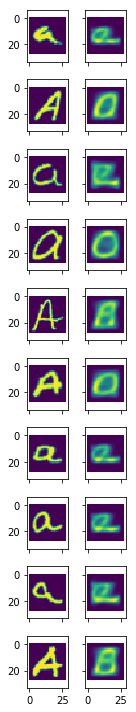

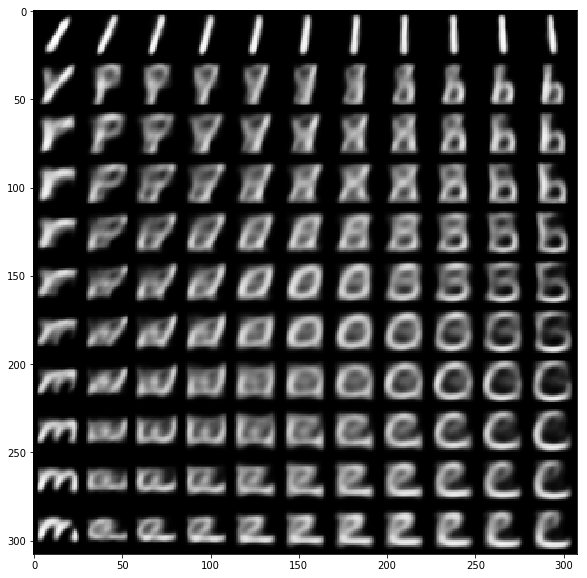

In [32]:
evaluate(X_test,vae)

In [24]:
def filter_char(X, y, chars):
    if type(chars) is not list:
        chars = [chars]
    idxs, chs = zip(*[(idx, ch) for idx, ch in enumerate(y) if ch in chars])
    return X[np.array(idxs)], chs

In [25]:
X_train_vowels, y_train_vowels = filter_char(X_train, y_train, ["A","E","I","O","U"])
X_test_vowels, y_test_vowels = filter_char(X_test, y_test, ["A","E","I","O","U"])

In [26]:
vae_vowels = create_vae()

In [29]:
vae_vowels.fit(X_train_vowels, X_train_vowels, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test_vowels, X_test_vowels), verbose=1, callbacks=[EarlyStopping(patience=4)])

Train on 17088 samples, validate on 3200 samples
Epoch 1/100
17088/17088 [==============================] - 3s 163us/step - loss: 230.5454 - val_loss: 221.9375
Epoch 2/100
17088/17088 [==============================] - 3s 163us/step - loss: 229.1417 - val_loss: 219.8915
Epoch 3/100
17088/17088 [==============================] - 3s 163us/step - loss: 227.2388 - val_loss: 219.1716
Epoch 4/100
17088/17088 [==============================] - 3s 164us/step - loss: 225.6957 - val_loss: 217.8425
Epoch 5/100
17088/17088 [==============================] - 3s 162us/step - loss: 224.1183 - val_loss: 217.5687
Epoch 6/100
17088/17088 [==============================] - 3s 163us/step - loss: 222.9965 - val_loss: 216.3125
Epoch 7/100
17088/17088 [==============================] - 3s 164us/step - loss: 221.8802 - val_loss: 214.8392
Epoch 8/100
17088/17088 [==============================] - 3s 164us/step - loss: 221.0243 - val_loss: 213.4392
Epoch 9/100
17088/17088 [==============================] - 3s 1

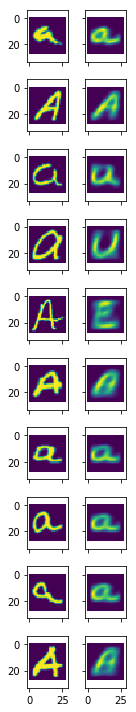

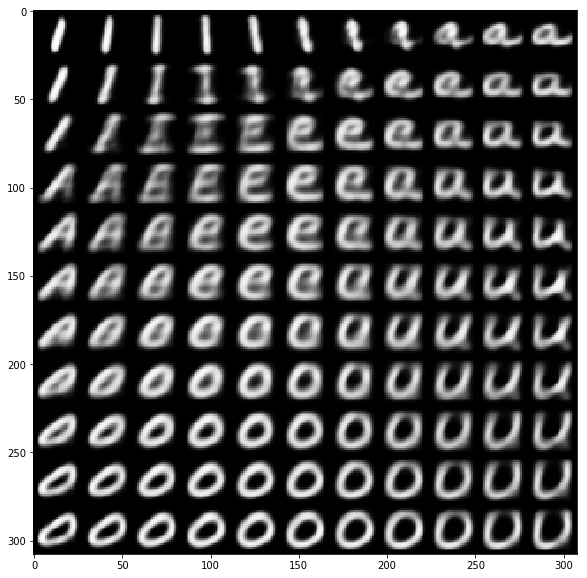

In [30]:
evaluate(X_test_vowels,vae_vowels)